<a href="https://colab.research.google.com/github/julwdo/thesis/blob/main/01_codes/03_nlp_project_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.float_format", "{:.6f}".format)

In [22]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import skew

sns.set(style="whitegrid")

def plot_numeric(df, feature, label_col="label", bins=50, palette=None, auto_log=True):
  """
  Plot normalized histogram of a numeric feature by label.
  Automatically log-transforms highly skewed features if auto_log=True.
  """
  data = df.copy()
  plot_feature = feature

  # Determine if log-transform is needed
  if auto_log:
      feature_skew = skew(data[feature].dropna())
      if feature_skew > 2:
          plot_feature = "log_" + feature
          data[plot_feature] = np.log1p(data[feature])

  # Compute weights to normalize counts per label
  weights = data.groupby(label_col).transform(lambda x: 1 / len(x))

  plt.figure(figsize=(8, 5))
  sns.histplot(
      data=data,
      x=plot_feature,
      hue=label_col,
      bins=bins,
      weights=weights[feature],
      palette=palette or {"bot": "red", "human": "blue"},
      alpha=0.6
  )
  plt.xlabel(feature)
  plt.ylabel("Relative frequency")
  plt.title(f"{feature} by {label_col} (normalized)")
  plt.show()

def plot_boolean(df, feature, label_col="label", palette=None):
    """
    Plot relative proportions of a boolean feature by label.
    """

    # Compute proportions per label
    prop_df = (
        df
        .groupby(label_col)[feature]
        .value_counts(normalize=True)
        .rename("proportion")
        .reset_index()
    )

    plt.figure(figsize=(6, 4))
    sns.barplot(
        data=prop_df,
        x=feature,
        y="proportion",
        hue=label_col,
        palette=palette or {"bot": "red", "human": "blue"}
    )

    plt.xlabel(feature)
    plt.ylabel("Proportion")
    plt.title(f"{feature} by label")
    plt.show()

In [24]:
import pyarrow.parquet as pq

path = "/content/drive/MyDrive/twibot-22/processed"

tweet_features = pd.read_parquet(f"{path}/tweet_features.parquet", engine='pyarrow')

In [25]:
n_rows, n_columns = tweet_features.shape
print(f"The dataset contains {n_rows} rows and {n_columns} columns.")

The dataset contains 1048873 rows and 11 columns.


In [26]:
tweet_features.head()

,author_id,id,text,created_at,is_reply,is_sensitive,like_count,quote_count,reply_count,retweet_count,label
0,u1001495628738957312,t1502310945158275074,"Join us for a special screening of the documentary #SAPELO and a Q&amp;A with the filmmakers on Thursday, March 31 at the <USER>!📽️🇨🇭 <USER> <USER> <URL>",2022-03-11 15:50:15+00:00,0,0,1,0.000000,0.000000,1,human
1,u1002590470097154048,t1459274835377500161,Looking forward to meeting the final chapter👀👀 <URL>,2021-11-12 21:40:07+00:00,0,0,0,NaN,NaN,0,bot
2,u1002590470097154048,t1405835036847443969,"RT <USER>: Our new service robot is getting ready to be used in amazing researches on ""generalizable perception and manipulation…",2021-06-18 10:29:26+00:00,0,0,0,NaN,NaN,1,bot
3,u1002590470097154048,t1401642372044296199,"RT <USER>: I'm happy to be a finalist for the ICRA Best Paper Award &amp; grateful to coauthors <USER>, Zhiyong, <USER>. I t…",2021-06-06 20:49:17+00:00,0,0,0,NaN,NaN,3,bot
4,u1002590470097154048,t1379337484384014336,"RT <USER>: The Conference on #Robot #Learning 2021 will be held on Nov 8-11 in London, UK &amp; virtually. Exciting new changes, including:…",2021-04-06 07:37:37+00:00,0,0,0,NaN,NaN,44,bot


In [27]:
tweet_features.dtypes

,0
author_id,object
id,object
text,object
created_at,object
is_reply,int32
is_sensitive,int32
like_count,int64
quote_count,float64
reply_count,float64
retweet_count,int64


In [28]:
tweet_features["is_reply"] = tweet_features["is_reply"].astype(bool)
tweet_features["is_sensitive"] = tweet_features["is_sensitive"].astype(bool)

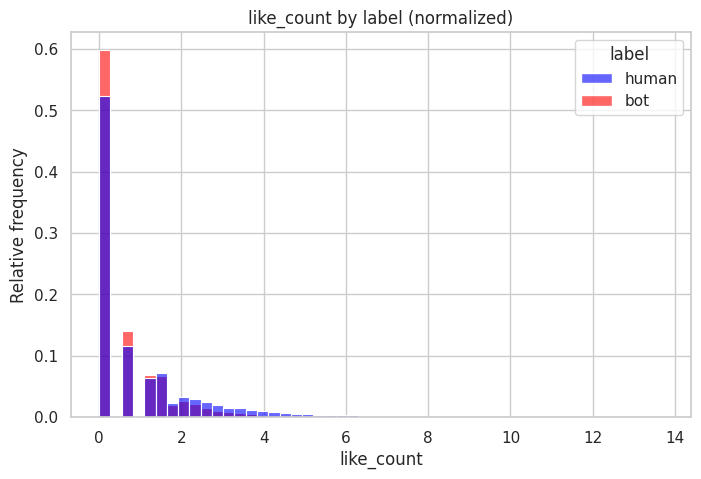

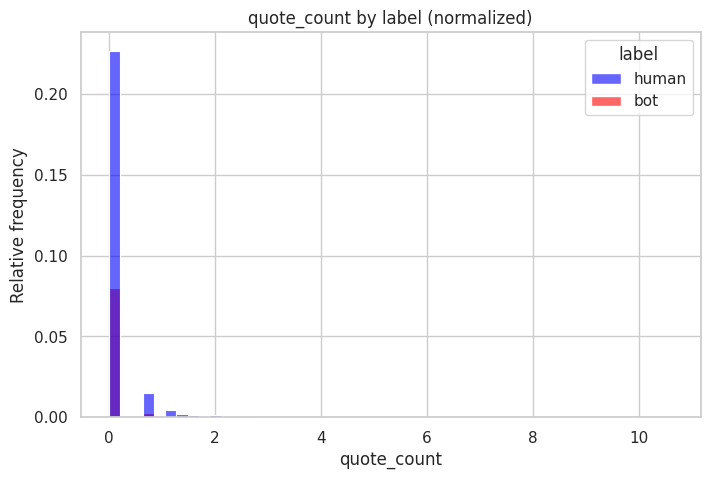

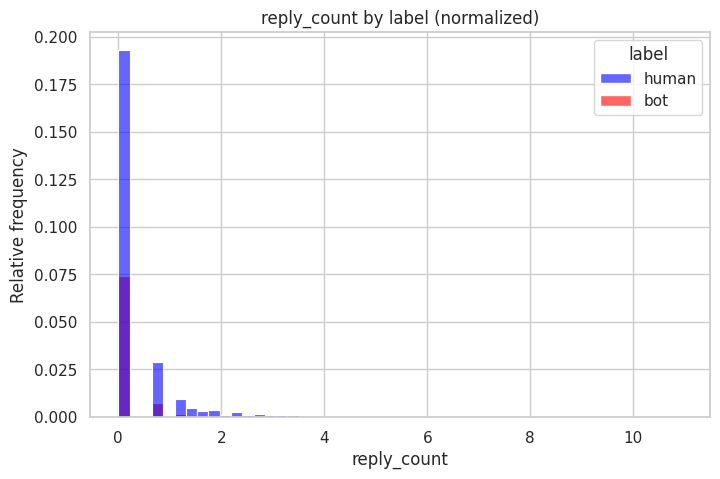

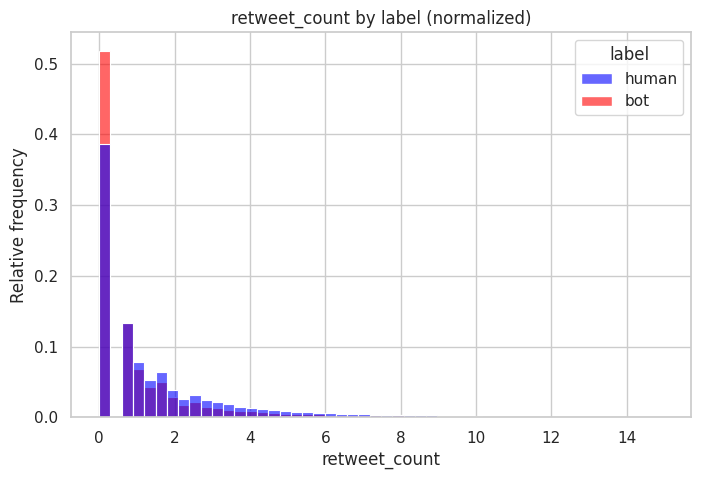

In [29]:
numeric_cols = tweet_features.select_dtypes(include=np.number).columns

for col in numeric_cols:
  plot_numeric(tweet_features, col)

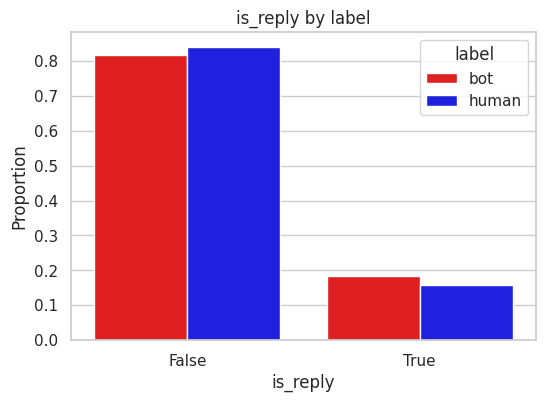

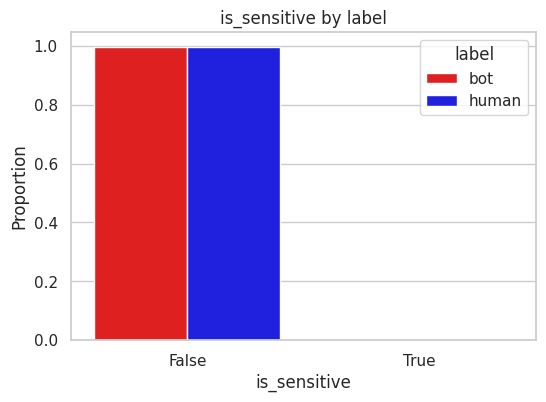

In [30]:
bool_cols = tweet_features.select_dtypes(include=['bool']).columns

for col in bool_cols:
  plot_boolean(tweet_features, col)

In [31]:
# Check for missing values
if tweet_features.isnull().any().any():
    print("Missing values found in the dataset.")
    na_summary = tweet_features.isnull().sum().loc[lambda x: x > 0].to_frame(name='Missing Count')
    na_summary['Missing Percentage'] = (na_summary['Missing Count'] / tweet_features.shape[0]) * 100
    print("\nSummary of missing values:")
    print(na_summary)
else:
    print("No missing values found in the dataset.")

Missing values found in the dataset.

Summary of missing values:
             Missing Count  Missing Percentage
quote_count         796093           75.899847
reply_count         796093           75.899847


In [32]:
bots = tweet_features[tweet_features['label'] == 'bot']
humans = tweet_features[tweet_features['label'] == 'human']

def check_missing(df, label):
    if df.isnull().any().any():
        print(f"\nMissing values found for {label}:")
        na_summary = df.isnull().sum().loc[lambda x: x > 0].to_frame(name='Missing Count')
        na_summary['Missing Percentage'] = (na_summary['Missing Count'] / df.shape[0]) * 100
        print(na_summary)
    else:
        print(f"\nNo missing values found for {label}.")

check_missing(bots, "bots")
check_missing(humans, "humans")


Missing values found for bots:
             Missing Count  Missing Percentage
quote_count          86243           91.558910
reply_count          86243           91.558910

Missing values found for humans:
             Missing Count  Missing Percentage
quote_count         709850           74.354835
reply_count         709850           74.354835


In [33]:
for col in ['quote_count', 'reply_count']:
  tweet_features[f"{col}_missing"] = tweet_features[col].isnull().astype(bool)
  tweet_features[col] = tweet_features[col].fillna(0)

In [34]:
# Check for missing values
if tweet_features.isnull().any().any():
    print("Missing values found in the dataset.")
    na_summary = tweet_features.isnull().sum().loc[lambda x: x > 0].to_frame(name='Missing Count')
    na_summary['Missing Percentage'] = (na_summary['Missing Count'] / tweet_features.shape[0]) * 100
    print("\nSummary of missing values:")
    print(na_summary)
else:
    print("No missing values found in the dataset.")

No missing values found in the dataset.


In [35]:
tweet_features.head(1)

,author_id,id,text,created_at,is_reply,is_sensitive,like_count,quote_count,reply_count,retweet_count,label,quote_count_missing,reply_count_missing
0,u1001495628738957312,t1502310945158275074,"Join us for a special screening of the documentary #SAPELO and a Q&amp;A with the filmmakers on Thursday, March 31 at the <USER>!📽️🇨🇭 <USER> <USER> <URL>",2022-03-11 15:50:15+00:00,False,False,1,0.000000,0.000000,1,human,False,False


In [36]:
# Cast label column: 1 if "bot", 0 if "human"
tweet_features['label'] = tweet_features['label'].map({'human': 0, 'bot': 1})

In [40]:
tweet_features['created_at'] = pd.to_datetime(tweet_features['created_at'])
tweet_features.head(2)

,author_id,id,text,created_at,is_reply,is_sensitive,like_count,quote_count,reply_count,retweet_count,label,quote_count_missing,reply_count_missing
0,u1001495628738957312,t1502310945158275074,"Join us for a special screening of the documentary #SAPELO and a Q&amp;A with the filmmakers on Thursday, March 31 at the <USER>!📽️🇨🇭 <USER> <USER> <URL>",2022-03-11 15:50:15+00:00,False,False,1,0.000000,0.000000,1,0,False,False
1,u1002590470097154048,t1459274835377500161,Looking forward to meeting the final chapter👀👀 <URL>,2021-11-12 21:40:07+00:00,False,False,0,0.000000,0.000000,0,1,True,True


In [63]:
tweet_features['date'] = tweet_features['created_at'].dt.date
tweet_features['hour'] = tweet_features['created_at'].dt.hour

In [66]:
hour_dist = tweet_features.groupby('author_id')['hour'].value_counts(normalize=True).unstack(fill_value=0)
hour_dist = hour_dist.sort_index(axis=1)
hour_dist.columns = [f'hour_{h}' for h in hour_dist.columns]

daily_counts = tweet_features.groupby(['author_id', 'date']).size().reset_index(name='tweets_per_day')
tweet_rate_std = daily_counts.groupby('author_id')['tweets_per_day'].std().fillna(0)

active_days = daily_counts.groupby('author_id').size()

In [42]:
tweets_per_user = tweet_features.groupby('author_id').agg(
    first_date=('created_at', 'min'),
    last_date=('created_at', 'max'),
    tweet_count=('id', 'count')
)

In [69]:
tweets_per_user['days_active'] = (tweets_per_user['last_date'] - tweets_per_user['first_date']).dt.days + 1
tweets_per_user['hours_active'] = ((tweets_per_user['last_date'] - tweets_per_user['first_date']).dt.total_seconds() / 3600).clip(lower=1)

tweets_per_user['tweets_per_day'] = tweets_per_user['tweet_count'] / tweets_per_user['days_active']
tweets_per_user['tweets_per_hour'] = tweets_per_user['tweet_count'] / tweets_per_user['hours_active']

tweets_per_user['tweet_rate_std'] = tweet_rate_std
tweets_per_user['active_days'] = active_days
tweets_per_user['active_days_ratio'] = tweets_per_user['active_days'] / tweets_per_user['days_active']

user_features = tweets_per_user.join(hour_dist, how='left')
user_features.reset_index(inplace=True)

In [72]:
user_features = user_features.join(tweet_features[["author_id", "label"]], how='left', on='author_id')

ValueError: You are trying to merge on object and int64 columns for key 'author_id'. If you wish to proceed you should use pd.concat